# **Taller 1**

<table align='left'>
<tr>
<td><img src='https://mhittesdorf.files.wordpress.com/2013/02/cropped-trading12.jpg' width='850'/></td>
</tr>
</table>


# Introducción

La simulación es una técnica computacional que permite modelar procesos o sistemas del mundo real para imitar su comportamiento. Implica crear un entorno virtual para observar y analizar cómo interactúan varios factores, permitiendo la experimentación sin afectar el sistema real. Las simulaciones son valiosas para probar hipótesis científicas, hacer predicciones para la toma de decisiones, optimizar procesos industriales y comprender fenómenos complejos en campos como la ciencia y la ingeniería. En el ámbito financiero, las simulaciones son especialmente útiles para modelar riesgos, valorar activos, simular escenarios económicos y evaluar estrategias de inversión, proporcionando información crucial para la toma de decisiones en un entorno económico dinámico.



En este taller simularemos comportamiento de los precios de ciertos activos en el tiempo utilizando un modelo estocástico sencillo denominado "Movimiento Browniano Geométrico" (GBM). Este modelo se ha utilizado para modelar diversos tipos de instrumentos financieros, incluyendo acciones, bonos, materias primas y criptomonedas como Bitcoin.

# Disclaimer

El modelo y los instrumentos financieros estudiados en este taller han sido seleccionados con fines puramente académicos.  
Las conclusiones que puedan derivarse de este taller podrían no reflejar la realidad con precisión y en ningún caso deben entenderse como un consejo de inversión.

# Modelo

El modelo GBM se utiliza para describir la dinámica del precio de un activo $S$ a lo largo del tiempo $t$. Se define mediante la siguiente ecuación diferencial estocástica:

\begin{align}
dS_t &= \mu S_t dt + \sigma S_t dW_t \, ,
\end{align}
donde



*  $S_t$ es el precio del activo en el tiempo $t$.
*  $\mu$ es la tasa promedio de retorno (deriva) del activo.
*  $\sigma$ es la volatilidad de los rendimientos del activo.
*  $W_t$ es un proceso de Wiener (movimiento Browniano) que representa la componente aleatoria.


En forma discreta y considerando incrementos temporales constantes $dt=1$,la ecuación se puede escribir como:
\begin{align}
R_t = \frac{S_{t+1}-S_t}{S_t} &= \mu + \sigma S_t Z_t \, ,
\end{align}
donde
*  $R_t$ es el retorno en el tiempo $t$.
*  $Z_t$ es variable aleatoria independiente de cualquier información del pasado.


# Datos & Libs

Utilizaremos algunas librerías básicas de Python para trabajo con datos.

In [69]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(8,4)})

from scipy.stats import norm, lognorm, t, laplace
import scipy.stats as stats
sns.set(rc={'figure.figsize':(8,4)})
plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)

Utilizaremos datos correspondientes al precio del oro (GC:F) y del Bitcoin en dólares americanos (USD). Para descargarlos podemos emplear la librería yfinance.

In [70]:
#!pip install yfinance > /dev/null
import yfinance as yf

In [71]:
def pre_process(finance_dataframe):
  finance_dataframe = finance_dataframe.rename(columns = {'Close':'price'})
  finance_dataframe.index.name = 'timestamp'
  finance_dataframe['timestamp'] = finance_dataframe.index
  finance_dataframe.reset_index(drop=True, inplace=True)
  finance_dataframe.timestamp = pd.to_datetime(finance_dataframe.timestamp, unit='s').dt.tz_localize(None)
  finance_dataframe.set_index(finance_dataframe.timestamp, inplace=True)
  finance_dataframe.drop(['timestamp'], axis=1, inplace=True)
  finance_dataframe.sort_values(by='timestamp', inplace = True)
  finance_dataframe['delta'] = finance_dataframe.diff().price
  finance_dataframe = finance_dataframe.dropna()
  finance_dataframe['return'] = finance_dataframe.delta/finance_dataframe.price
  finance_dataframe['logprice'] = np.log(1+finance_dataframe.price)
  return finance_dataframe

In [72]:
btc_data = yf.download('BTC-USD', interval = '1d')[['Close']]
btc_data = pre_process(btc_data)
print(btc_data.head(5))
print("Fecha Mínima: ", btc_data.iloc[[0]].index)
print("Fecha Máxima: ", btc_data.iloc[[-1]].index)

[*********************100%%**********************]  1 of 1 completed
                 price      delta    return  logprice
timestamp                                            
2014-09-18  424.440002 -32.894012 -0.077500  6.053124
2014-09-19  394.795990 -29.644012 -0.075087  5.980899
2014-09-20  408.903992  14.108002  0.034502  6.015923
2014-09-21  398.821014 -10.082977 -0.025282  5.991017
2014-09-22  402.152008   3.330994  0.008283  5.999314
Fecha Mínima:  DatetimeIndex(['2014-09-18'], dtype='datetime64[ns]', name='timestamp', freq=None)
Fecha Máxima:  DatetimeIndex(['2023-09-08'], dtype='datetime64[ns]', name='timestamp', freq=None)


In [73]:
gold_data = yf.download('GC=F', interval = '1d')[['Close']]
gold_data = pre_process(gold_data)
print(gold_data.head(5))
print("Fecha Mínima: ", gold_data.iloc[[0]].index)
print("Fecha Máxima: ", gold_data.iloc[[-1]].index)

[*********************100%%**********************]  1 of 1 completed
                 price     delta    return  logprice
timestamp                                           
2000-08-31  278.299988  4.399994  0.015810  5.632286
2000-09-01  277.000000 -1.299988 -0.004693  5.627621
2000-09-05  275.799988 -1.200012 -0.004351  5.623295
2000-09-06  274.200012 -1.599976 -0.005835  5.617498
2000-09-07  274.000000 -0.200012 -0.000730  5.616771
Fecha Mínima:  DatetimeIndex(['2000-08-31'], dtype='datetime64[ns]', name='timestamp', freq=None)
Fecha Máxima:  DatetimeIndex(['2023-09-07'], dtype='datetime64[ns]', name='timestamp', freq=None)


In [74]:
eth_data = yf.download('ETH-USD', interval = '1d')[['Close']]
eth_data = pre_process(eth_data)
print(eth_data.head(5))
print("Fecha Mínima: ", eth_data.iloc[[0]].index)
print("Fecha Máxima: ", eth_data.iloc[[-1]].index)

[*********************100%%**********************]  1 of 1 completed
                 price      delta    return  logprice
timestamp                                            
2017-11-10  299.252991 -21.631012 -0.072283  5.704625
2017-11-11  314.681000  15.428009  0.049027  5.754732
2017-11-12  307.907990  -6.773010 -0.021997  5.733043
2017-11-13  316.716003   8.808014  0.027810  5.761158
2017-11-14  337.631012  20.915009  0.061946  5.824911
Fecha Mínima:  DatetimeIndex(['2017-11-10'], dtype='datetime64[ns]', name='timestamp', freq=None)
Fecha Máxima:  DatetimeIndex(['2023-09-08'], dtype='datetime64[ns]', name='timestamp', freq=None)


In [75]:
btc_data_history = btc_data.loc[(btc_data.index >= '2014-09-18') & (btc_data.index <= '2022-08-16')]
btc_data_future= btc_data.loc[(btc_data.index >= '2022-08-17') & (btc_data.index <= '2023-08-17')]

In [76]:
gold_data_history = gold_data.loc[(gold_data.index >= '2000-08-31') & (gold_data.index <= '2022-08-16')]
gold_data_future = gold_data.loc[(gold_data.index >= '2022-08-17') & (gold_data.index <= '2023-08-17')]

In [77]:
eth_data_history = eth_data.loc[(eth_data.index >= '2000-08-31') & (eth_data.index <= '2022-08-16')]
eth_data_future = eth_data.loc[(eth_data.index >= '2022-08-17') & (eth_data.index <= '2023-08-17')]

# Taller 07 de Septiembre

1. **[20 pts]** Asumiendo independencia de los valores de ambos instrumentos financieros y adoptando un modelo normal, use la ley de los grandes números para estimar la probabilidad de que en 1 día ETH rente más que BTC. Para esto, varíe la cantidad de simulaciones (10,100,1000 y 10.000) y compare en su análisis como se contrastan los valores simulados con el valor real.
2. **[30 pts]** Partiendo del valor observado el 17 de Agosto de 2022, simule los valores de cada activo 5 años hacia adelante. Para simular los valores de $Z_t$ considere que los retornos diarios siguen una distribución normal. Grafique 1000 trayectorias posibles y compute los percentiles 80 y 20 para cada tiempo t. Además, obtenga la probabilidad de que se obtengan ganancias al cabo de 5 años. **Importante:** se considerará que se obtienen ganancias si el valor del activo al final de los 5 años es mayor que su valor inicial.

Hasta ahora, se ha analizado la evolución del valor de los activos a lo largo de los años. Sin embargo, no se ha tomado en cuenta que el poder adquisitivo del dinero cambia debido a la inflación. Por esto, usted piensa en invertir en un activo que obtenga utilidades que "compensen" la inflación a lo largo de los años.

3. **[30 pts]** Considere que la tasa de inflación anual se distribuye normal con media 1.03 y desviación estándar 0.01. Obtenga mediante simulación la tasa de inflación acumulada luego de 5 años. ¿Cuál es la tasa de inflación acumulada esperada? Grafique sus resultados y determine el P80. ¿Es correcto afirmar que la tasa de inflación acumulada esperada luego de 5 años es igual a E(X)^5?, ¿Es correcto afirmar que, de manera general, para una distribución $X$ se cumple que $E(X^k) = E(X)^k$?
4. **[20 pts]** Como usted es una persona pesimista, piensa que la tasa de inflación acumulada en los próximos 5 años será igual al P80 obtenido en la pregunta 3. Considerando la inflación y las simulaciones realizadas en la pregunta 2, ¿Cuál es la probabilidad, para cada activo, de realmente obtener ganancias?

# Desarrollo

1) Asumiendo independencia de los valores de ambos instrumentos financieros y adoptando un modelo normal, use la ley de los grandes números para estimar la probabilidad de que en 1 día ETH rente más que BTC. Para esto, varíe la cantidad de simulaciones (10,100,1000 y 10.000) y compare en su análisis como se contrastan los valores simulados con el valor real.

In [79]:
#Definiendo RV de BitCoin y Ethereum
mu_btc = np.mean(btc_data["return"].values)
sigma_btc = np.std(btc_data["return"].values, ddof=1)

mu_eth = np.mean(eth_data["return"].values)
sigma_eth = np.std(eth_data["return"].values, ddof=1)

rv_btc = norm(loc=mu_btc,scale=sigma_btc)
rv_eth = norm(loc=mu_eth,scale=sigma_eth)

In [80]:
NSIMS = 10
simulaciones_btc = rv_btc.rvs(size=NSIMS)
simulaciones_eth = rv_eth.rvs(size=NSIMS)
p_eth_better10 = np.sum(simulaciones_eth > simulaciones_btc)/NSIMS
print(p_eth_better10)

0.5


In [81]:
NSIMS = 100
simulaciones_btc = rv_btc.rvs(size=NSIMS)
simulaciones_eth = rv_eth.rvs(size=NSIMS)
p_eth_better100 = np.sum(simulaciones_eth > simulaciones_btc)/NSIMS
print(p_eth_better100)

0.57


In [87]:
NSIMS = 1000
simulaciones_btc = rv_btc.rvs(size=NSIMS)
simulaciones_eth = rv_eth.rvs(size=NSIMS)
p_eth_better1000 = np.sum(simulaciones_eth > simulaciones_btc)/NSIMS
print(p_eth_better1000)

0.5


In [90]:
NSIMS = 10000
simulaciones_btc = rv_btc.rvs(size=NSIMS)
simulaciones_eth = rv_eth.rvs(size=NSIMS)
p_eth_better10000 = np.sum(simulaciones_eth > simulaciones_btc)/NSIMS
print(p_eth_better10000)

0.4918


In [84]:
#VALOR REAL
joined = btc_data.merge(eth_data,left_index=True, right_index=True,suffixes=('_btc', '_eth'))
p_eth_better = np.sum(joined['return_eth'] > joined['return_btc'])/len(joined)

print("Probabilidad real: ", p_eth_better)
print("\nProbabilidad 10 sim: ", p_eth_better10, "  Diferencia con el valor real: ",  p_eth_better - p_eth_better10)
print("Probabilidad 100 sim: ", p_eth_better100, "  Diferencia con el valor real: ",  p_eth_better - p_eth_better100)
print("Probabilidad 1000 sim: ", p_eth_better1000, "  Diferencia con el valor real: ",  p_eth_better - p_eth_better1000)
print("Probabilidad 10000 sim: ", p_eth_better10000, "  Diferencia con el valor real: ",  p_eth_better - p_eth_better10000)


Probabilidad real:  0.47603383458646614

Probabilidad 10 sim:  0.5   Diferencia con el valor real:  -0.023966165413533858
Probabilidad 100 sim:  0.57   Diferencia con el valor real:  -0.09396616541353381
Probabilidad 1000 sim:  0.492   Diferencia con el valor real:  -0.01596616541353385
Probabilidad 10000 sim:  0.4946   Diferencia con el valor real:  -0.01856616541353384


RESPUESTA: A medida que se aumenta el número de simulaciones se va acercando al valor real de la probabilidad que el ETH rente más que BTC en 1 día.

2) Partiendo del valor observado el 17 de Agosto de 2022, simule los valores de cada activo 5 años hacia adelante. Para simular los valores de $Z_t$ considere que los retornos diarios siguen una distribución normal. Grafique 1000 trayectorias posibles y compute los percentiles 80 y 20 para cada tiempo t. Además, obtenga la probabilidad de que se obtengan ganancias al cabo de 5 años. **Importante:** se considerará que se obtienen ganancias si el valor del activo al final de los 5 años es mayor que su valor inicial.

In [91]:
#Calcula el St+1, precio del activo en el tiempo t+1
def simulate_one_from_dist(ndays,starting_price,rv):
    simulated_values = np.zeros(ndays)
    simulated_values[0] = starting_price
    for i in range(1,ndays):
      return_value = rv.rvs(size=1)
      value = (1+return_value)*simulated_values[i-1]
      simulated_values[i] = value
    return simulated_values

def simulate_many_from_dist(nsims,ndays,retorno_inicial,rv):
    simulated_values = np.zeros((nsims,ndays))
    for i in range(nsims):
      simulated_values[i,:] = simulate_one_from_dist(ndays,retorno_inicial,rv)
    return simulated_values

In [92]:
future_btc_mean = np.mean(btc_data_future["return"].values)
future_btc_std = np.std(btc_data_future["return"].values)

future_gold_mean = np.mean(gold_data_future["return"].values)
future_gold_std = np.std(gold_data_future["return"].values)

future_eth_mean = np.mean(eth_data_future["return"].values)
future_eth_std = np.std(eth_data_future["return"].values)

rv_btc_future = norm(loc=future_btc_mean, scale=future_btc_std)
rv_eth_future = norm(loc=future_eth_mean, scale=future_eth_std)
rv_gold_future = norm(loc=future_gold_mean, scale=future_gold_std)

In [ ]:
#SIMULANDO VALORES DE ACTIVOS
NSIMS = 1000
ndays = 5*365

btc_starting_value = btc_data_future.iloc[0].price
gold_starting_value = gold_data_future.iloc[0].price
eth_starting_value = eth_data_future.iloc[0].price

sim_values_btc = simulate_many_from_dist(NSIMS,ndays,btc_starting_value,rv_btc_future)
sim_values_gold = simulate_many_from_dist(NSIMS,ndays,btc_starting_value,rv_gold_future)
sim_values_eth = simulate_many_from_dist(NSIMS,ndays,eth_starting_value,rv_eth_future)

La simulación demora en cargar aproximadamente unos 6 minutos para 1000 simulaciones

In [ ]:
# PERCENTIL 20 y 80
low_btc = np.quantile(sim_values_btc,q=0.2,axis=0)
up_btc = np.quantile(sim_values_btc,q=0.8,axis=0)

low_gold = np.quantile(sim_values_gold,q=0.2,axis=0)
up_gold = np.quantile(sim_values_gold,q=0.8,axis=0)

low_eth = np.quantile(sim_values_eth,q=0.2,axis=0)
up_eth = np.quantile(sim_values_eth,q=0.8,axis=0)

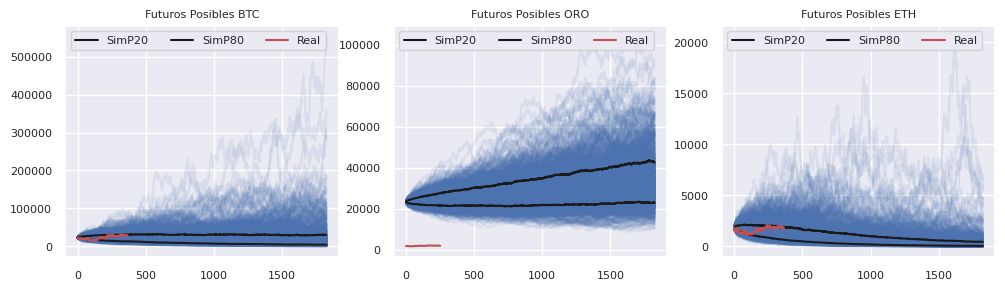

In [ ]:
#Graficas
NSIMS = 1000
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=3)
for i in range(NSIMS):
  ax[0].plot(sim_values_btc[i,:],color='b',alpha=0.1)
ax[0].plot(low_btc,color='k',label='SimP20')
ax[0].plot(up_btc,color='k',label='SimP80')
ax[0].plot(btc_data_future['price'].values,color='r',label='Real')
ax[0].set_title('Futuros Posibles BTC',size=8)
ax[0].legend(loc='upper left',fontsize=8,ncol=3)

for i in range(NSIMS):
  ax[1].plot(sim_values_gold[i,:],color='b',alpha=0.1)
ax[1].plot(low_gold,color='k',label='SimP20')
ax[1].plot(up_gold,color='k',label='SimP80')
ax[1].plot(gold_data_future['price'].values,color='r',label='Real')
ax[1].set_title('Futuros Posibles ORO',size=8)
ax[1].legend(loc='upper left',fontsize=8,ncol=3)

for i in range(NSIMS):
  ax[2].plot(sim_values_eth[i,:],color='b',alpha=0.1)
ax[2].plot(low_eth,color='k',label='SimP20')
ax[2].plot(up_eth,color='k',label='SimP80')
ax[2].plot(eth_data_future['price'].values,color='r',label='Real')
ax[2].set_title('Futuros Posibles ETH',size=8)
ax[2].legend(loc='upper left',fontsize=8,ncol=3)

In [ ]:
NSIMS = 1000
ndays = 5*365
prob_btc = np.sum(sim_values_btc[:,0] < sim_values_btc[:, -1])
prob_btc = prob_btc/(NSIMS*ndays)
print("Probabilidad Ganancia BTC: ",prob_btc)

prob_gold = np.sum(sim_values_gold[:,0] < sim_values_gold[:, -1])
prob_gold = prob_gold/(NSIMS*ndays)
print("Probabilidad Ganancia Gold: ",prob_gold)

prob_eth = np.sum(sim_values_eth[:,0] < sim_values_eth[:, -1])
prob_eth = prob_eth/(NSIMS*ndays)
print("Probabilidad Ganancia ETH: ",prob_eth)

Probabilidad Ganancia BTC:  1.4684931506849315e-05
Probabilidad Ganancia Gold:  4.334246575342466e-05
Probabilidad Ganancia ETH:  1.589041095890411e-06


 3) Considere que la tasa de inflación anual se distribuye normal con media 1.03 y desviación estándar 0.01. Obtenga mediante simulación la tasa de inflación acumulada luego de 5 años. ¿Cuál es la tasa de inflación acumulada esperada? Grafique sus resultados y determine el P80. ¿Es correcto afirmar que la tasa de inflación acumulada esperada luego de 5 años es igual a E(X)^5?, ¿Es correcto afirmar que, de manera general, para una distribución  X  se cumple que  E(Xk)=E(X)k ?

In [ ]:
NSIMS = 10000
rv_inflacion_anual = norm(loc=1.03, scale= 0.01)
years = 5

simulaciones_inflacion_5years = np.zeros(NSIMS)
for i in range(NSIMS):
    fiveyearsArray = rv_inflacion_anual.rvs(size=years)
    simulaciones_inflacion_5years[i] = np.prod(fiveyearsArray)

valor_esperado_inf5years = np.mean(simulaciones_inflacion_5years)
print("Valor esperado acumulado en 5 anios: ", valor_esperado_inf5years)
a = 1.03**5
print("E(X)^5: ",a)
print("Diferencia: ", valor_esperado_inf5years - a)

Valor esperado acumulado en 5 anios:  1.1591781620484387
E(X)^5:  1.1592740743
Diferencia:  -9.591225156135863e-05


3) Respuesta: Para un total de 10.000 simulaciones la diferencia entre el valor esperado^5 y el valor esperado acumulado en 5 años de forma simulada es muy baja, por lo que se podría decir que son iguales.

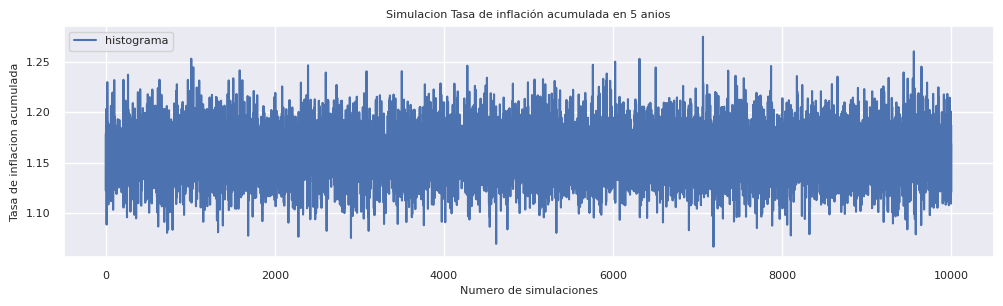

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3),nrows=1,ncols=1)

ax.plot(simulaciones_inflacion_5years, color='b',label='Sim5years')
plt.xlabel('Numero de simulaciones')
plt.ylabel('Tasa de inflacion acumulada')
ax.set_title('Simulacion Tasa de inflación acumulada en 5 anios',size=8)
ax.legend(['histograma'],fontsize=8,loc='upper left')

In [ ]:

q_inflacion_5acum_emp = np.quantile(simulaciones_inflacion_5years,q=0.8,axis=0)
print("Percentil 80 empirico: ", q_inflacion_5acum_emp)

Percentil 80 empirico:  1.180309852969166


RESPUESTA: De manera general, no se puede decir que para una distribución $X$ se cumple que $E(X^k) = E(X)^k$, ya que aquí se cumple debido a que tratamos con una distribucion normal, en la que el valor esperado es igual a la media, para otras distribuciones esto no se cumple.

4) Como usted es una persona pesimista, piensa que la tasa de inflación acumulada en los próximos 5 años será igual al P80 obtenido en la pregunta 3. Considerando la inflación y las simulaciones realizadas en la pregunta 2, ¿Cuál es la probabilidad, para cada activo, de realmente obtener ganancias?





In [ ]:
price_with_inflation_btc = sim_values_btc * q_inflacion_5acum_emp # Multiplica todos los valores simulados por la tasa acumulada
price_with_inflation_btc[:, 0] = price_with_inflation_btc[:, 0] * (1 / q_inflacion_5acum_emp) #Devuelve el precio del primer dia sin multiplicar por la tasa
prob_btc = np.sum(price_with_inflation_btc[:, 0] < price_with_inflation_btc[:, -1]) / (1000*5*365) # 1000 simulaciones y 5 anios
print("Probabilidad Ganancia Real BTC", prob_btc)

price_with_inflation_gold = sim_values_gold * q_inflacion_5acum_emp # Multiplica todos los valores simulados por la tasa acumulada
price_with_inflation_gold[:, 0] = price_with_inflation_gold[:, 0] * (1 / q_inflacion_5acum_emp) #Devuelve el precio del primer dia sin multiplicar por la tasa
prob_gold = np.sum(price_with_inflation_gold[:, 0] < price_with_inflation_gold[:, -1]) / (1000*5*365) # 1000 simulaciones y 5 anios
print("Probabilidad Ganancia Real Gold", prob_gold)

price_with_inflation_eth= sim_values_eth * q_inflacion_5acum_emp # Multiplica todos los valores simulados por la tasa acumulada
price_with_inflation_eth[:, 0] = price_with_inflation_eth[:, 0] * (1 / q_inflacion_5acum_emp) #Devuelve el precio del primer dia sin multiplicar por la tasa
prob_eth = np.sum(price_with_inflation_eth[:, 0] < price_with_inflation_eth[:, -1]) / (1000*5*365) # 1000 simulaciones y 5 anios
print("Probabilidad Ganancia Real ETH", prob_eth)

Probabilidad Ganancia Real BTC 0.00017808219178082192
Probabilidad Ganancia Real Gold 0.0004926027397260274
Probabilidad Ganancia Real ETH 1.9178082191780822e-05


RESPUESTA: La probabilidad de ganancia real del oro incluyendo la inflación es superior a la de los demás activos tomando en cuenta los resultados de las simulaciones realizadas en la pregunta 2.